<a href="https://colab.research.google.com/github/Neel1097/Nuclei-segmentation-Using-U-NET/blob/master/Nuclei_segementation_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ALL IMPORT**
All import to be made.

In [0]:
#All Imports
import os
import sys 
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# **Seeding**

In [0]:
#Seeding
seed = 2019
random.seed =seed
np.random.seed =seed
tf.seed = seed

# **Downloading Dataset from Kaggle**

In [0]:
# Colab library to upload files to notebook
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amit2497","key":"ba4905f08a3f89f677be6d96c8791de0"}'}

In [0]:
#Verify the Token is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Jan 22 23:53 kaggle.json


In [0]:
# Install Kaggle library
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#Downloading the dataset
!kaggle competitions download -c data-science-bowl-2018

 55% 5.00M/9.10M [00:00<00:00, 17.6MB/s]
100% 9.10M/9.10M [00:00<00:00, 26.2MB/s]
 87% 69.0M/79.1M [00:01<00:00, 27.6MB/s]
100% 79.1M/79.1M [00:01<00:00, 52.9MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 182MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 127MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 101MB/s]
 91% 252M/276M [00:05<00:00, 52.7MB/s]
100% 276M/276M [00:05<00:00, 55.9MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.57MB/s]


# **Unzipping the Downloaded File**

In [0]:
from google.colab import drive
import zipfile
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/stage1_train.zip", 'r')
zip_ref.extractall("/tmp/train")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Checking Extracted file Directory
print(os.listdir("/tmp/train"))

['4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9', '58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd', '1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073', 'e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661a42f38bf9248d291fd', 'e216ec5063d3562b793e434c491051bd8867f6c2e571e41137c7c560cc0e6a03', '33618678c167c5e07be02c49d0c43bcd90493ba5d83110a631409a4d3ccc1e51', '9774c82396327929fea05e40ae153cabf0107178b2ae3e40a5709b409793887e', 'c6216cdc42f61bc345434986db42e2ef9b9741aee3210b7a808e952e319d2305', 'a6e81120d1cb9f71f8a25f90a5d56c4b714a642fc496a705e38921fd90a3f69c', 'f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a', '139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5bc3382f8df9355443d', '947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050', '61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e', 'e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2', 'd256b32adda37f2301c9e46f34b7f9a36cce273256369c

# **Data Generator**
Data Is generated from the Downloaded File.

In [0]:
# Data Generator
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
         
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))



# **Hyperparameter**

(8, 128, 128, 3) (8, 128, 128, 1)


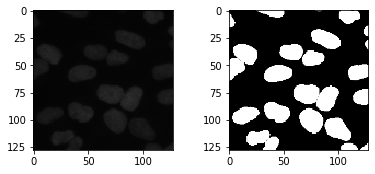

In [0]:
#Hyperparameter
image_size = 128
train_path = "/tmp/train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")


# **Designing the Training Model**

In [0]:
#U-Net Model
  inputs = keras.layers.Input((image_size,image_size,3))
  c0 = inputs
  ##Down-1
  c1 = keras.layers.Conv2D(16,(3,3), padding="same", strides=1, activation="relu")(c0)
  c1 = keras.layers.Conv2D(16,(3,3), padding="same", strides=1, activation="relu")(c1)
  p1 = keras.layers.MaxPool2D((2, 2), (2, 2))(c1)
  ##Down-2
  c2 = keras.layers.Conv2D(32,(3,3), padding="same", strides=1, activation="relu")(p1)
  c2 = keras.layers.Conv2D(32,(3,3), padding="same", strides=1, activation="relu")(c2)
  p2 = keras.layers.MaxPool2D((2, 2), (2, 2))(c2)
  ##Down-3
  c3 = keras.layers.Conv2D(64,(3,3), padding="same", strides=1, activation="relu")(p2)
  c3 = keras.layers.Conv2D(64,(3,3), padding="same", strides=1, activation="relu")(c3)
  p3 = keras.layers.MaxPool2D((2, 2), (2, 2))(c3)
  ##Down-4
  c4 = keras.layers.Conv2D(128,(3,3), padding="same", strides=1, activation="relu")(p3)
  c4 = keras.layers.Conv2D(128,(3,3), padding="same", strides=1, activation="relu")(c4)
  p4 = keras.layers.MaxPool2D((2, 2), (2, 2))(c4)
  ##Bottle-1
  bn = keras.layers.Conv2D(256, (3,3), padding="same", strides=1, activation="relu")(p4)
  bn = keras.layers.Conv2D(256, (3,3), padding="same", strides=1, activation="relu")(bn)
  ##Up-1
  us1 = keras.layers.UpSampling2D((2, 2))(bn)
  concat1 = keras.layers.Concatenate()([us1, c4])
  u1 = keras.layers.Conv2D(128, (3,3), padding="same", strides=1, activation="relu")(concat1)
  u1 = keras.layers.Conv2D(128, (3,3), padding="same", strides=1, activation="relu")(u1)
  ##Up-2
  us2 = keras.layers.UpSampling2D((2, 2))(u1)
  concat2 = keras.layers.Concatenate()([us2, c3])
  u2 = keras.layers.Conv2D(64, (3,3), padding="same", strides=1, activation="relu")(concat2)
  u2 = keras.layers.Conv2D(64, (3,3), padding="same", strides=1, activation="relu")(u2)
  ##Up-3
  us3 = keras.layers.UpSampling2D((2, 2))(u2)
  concat3 = keras.layers.Concatenate()([us3, c2])
  u3 = keras.layers.Conv2D(32, (3,3), padding="same", strides=1, activation="relu")(concat3)
  u3 = keras.layers.Conv2D(32, (3,3), padding="same", strides=1, activation="relu")(u3)
  ##Up-4
  us4 = keras.layers.UpSampling2D((2, 2))(u3)
  concat4 = keras.layers.Concatenate()([us4, c1])
  u4 = keras.layers.Conv2D(16, (3,3), padding="same", strides=1, activation="relu")(concat4)
  u4 = keras.layers.Conv2D(16, (3,3), padding="same", strides=1, activation="relu")(u4)
  ##Output
  outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = keras.models.Model(inputs, outputs)

# **Compiling the Model**

In [0]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                 

# **Training the Model**

In [0]:
#Training The Model
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
82/82 [==============================] - 23s 284ms/step - loss: 0.3575 - acc: 0.8502 - val_loss: 0.2530 - val_acc: 0.8977
Epoch 2/5
82/82 [==============================] - 15s 180ms/step - loss: 0.2277 - acc: 0.8671 - val_loss: 0.2399 - val_acc: 0.8834
Epoch 3/5
82/82 [==============================] - 15s 180ms/step - loss: 0.1505 - acc: 0.9248 - val_loss: 0.2167 - val_acc: 0.8868
Epoch 4/5
82/82 [==============================] - 14s 174ms/step - loss: 0.1241 - acc: 0.9354 - val_loss: 0.1749 - val_acc: 0.9185
Epoch 5/5
82/82 [==============================] - 15s 180ms/step - loss: 0.1141 - acc: 0.9399 - val_loss: 0.1579 - val_acc: 0.9157


# **Testing The Model**
Model which is training, is been tested by test set. 

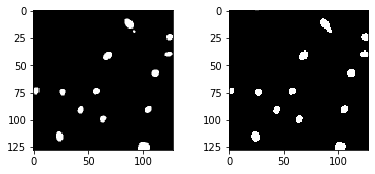

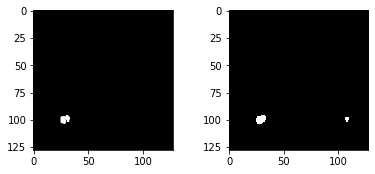

In [0]:
#Testing the model
## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5
##For Image 0

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0], (image_size, image_size)), cmap="gray")



#For the the image 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1], (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1], (image_size, image_size)), cmap="gray")